# Objective
 Predict the likelihood of a loan default and optimize the decision threshold based on cost-benefit analysis

In [4]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Dataset
Dataset Name: Loan Default Sample Dataset
Source: Kaggle

Target Variable
Default – Indicates whether the applicant defaulted on the loan (1 = Defaulted, 0 = Not Defaulted)

Features
- ID – Unique identifier for each loan application.
- Income – Total income of the applicant (in currency units).
- Credit_Amount – Total credit amount requested.
- Annuity – Monthly installment amount to be paid.
- Age – Age of the applicant.
- Employment_Status – Employment status of the applicant (e.g., Self-employed, Retired, Unemployed).
- Housing – Housing situation of the applicant (e.g., Free, Own).
- Marital_Status – Marital status of the applicant (e.g., Single, Married, Divorced).
- Children – Number of children the applicant has.
- Default – Binary label indicating if the applicant defaulted.

In [5]:
# Load dataset
data = pd.read_csv("Loan_Default_Sample.csv")

# Display basic info
print(data.shape)
print(data.dtypes)

(5000, 10)
ID                    int64
Income                int64
Credit_Amount         int64
Annuity               int64
Age                   int64
Employment_Status    object
Housing              object
Marital_Status       object
Children              int64
Default               int64
dtype: object


In [6]:
data.head()

,ID,Income,Credit_Amount,Annuity,Age,Employment_Status,Housing,Marital_Status,Children,Default
0,100001,174835,515248,19572,69,Self-employed,Free,Divorced,1,0
1,100002,143086,509317,22556,28,Retired,Free,Single,0,0
2,100003,182384,240871,20220,67,Unemployed,Free,Single,3,0
3,100004,226151,533981,25883,67,Unemployed,Own,Married,3,0
4,100005,138292,746565,34577,57,Retired,Free,Married,0,0


In [7]:
print(f"Original data shape: {data.shape}")
print(f"Missing values per column:\n{data.isnull().sum()}")

# Analyze class distribution
default_rate = data['Default'].mean()
print(f"Default rate: {default_rate:.3f} ({default_rate*100:.1f}%)")
print("Class distribution:")
print(f"  No Default (0): {(data['Default']==0).sum()} ({(data['Default']==0).mean()*100:.1f}%)")
print(f"  Default (1): {(data['Default']==1).sum()} ({(data['Default']==1).mean()*100:.1f}%)")

if default_rate < 0.05:
    print("WARNING: Very low default rate detected!")
    print("This is a highly imbalanced dataset. Using special techniques...")

# Fill missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'Default':
        data[col].fillna(data[col].median(), inplace=True)

categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Feature engineering
if 'Income' in data.columns and 'Credit_Amount' in data.columns:
    data['Debt_to_Income_Ratio'] = data['Credit_Amount'] / (data['Income'] + 1)
    data['Credit_per_Child'] = data['Credit_Amount'] / (data['Children'] + 1)

print(f"Cleaned data shape: {data.shape}")

Original data shape: (5000, 10)
Missing values per column:
ID                   0
Income               0
Credit_Amount        0
Annuity              0
Age                  0
Employment_Status    0
Housing              0
Marital_Status       0
Children             0
Default              0
dtype: int64
Default rate: 0.101 (10.1%)
Class distribution:
  No Default (0): 4496 (89.9%)
  Default (1): 504 (10.1%)
Cleaned data shape: (5000, 12)


C:\Users\DELL\AppData\Local\Temp\ipykernel_764\2486101408.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_764\2486101408.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [8]:
X = data.drop('Default', axis=1)
y = data['Default']

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
feature_names = X.columns.tolist()

In [11]:
models = {}
default_rate = y_train.mean()
is_imbalanced = default_rate < 0.1 or default_rate > 0.9

if is_imbalanced:
    print(f"Imbalanced data detected (default rate: {default_rate:.3f})")
    print("Using class balancing techniques...")

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print(f"Class weights: {class_weight_dict}")

# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_model

# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    min_samples_split=5,
    min_samples_leaf=2
)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model
print(f"Trained {len(models)} model(s) successfully.")

Class weights: {np.int64(0): np.float64(0.5560189046427578), np.int64(1): np.float64(4.962779156327543)}
Training Logistic Regression...
Training Random Forest...
Trained 2 model(s) successfully.


In [12]:
cost_fp = 15000
cost_fn = 3000
results = {}

print(f"\nCost per False Positive: ${cost_fp:,}")
print(f"Cost per False Negative: ${cost_fn:,}")
print(f"Test set: {y_test.sum()} defaults out of {len(y_test)} loans ({y_test.mean():.2%})")

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    probabilities = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"  Probability range: {probabilities.min():.4f} - {probabilities.max():.4f}")
    thresholds = np.linspace(0.001, 0.99, 100)
    if probabilities.max() < 0.5:
        thresholds = np.concatenate([
            np.linspace(0.001, 0.1, 50),
            np.linspace(0.1, probabilities.max() + 0.1, 31)
        ])
    thresholds = np.unique(thresholds)
    thresholds = thresholds[thresholds <= probabilities.max() + 0.01]

    costs = []
    for t in thresholds:
        preds = (probabilities >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        cost = (fp * cost_fp) + (fn * cost_fn)
        costs.append(cost)

    best_index = np.argmin(costs)
    best_threshold = thresholds[best_index]
    best_cost = costs[best_index]
    optimal_preds = (probabilities >= best_threshold).astype(int)

    default_preds = (probabilities >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, default_preds).ravel()
    default_cost = (fp * cost_fp) + (fn * cost_fn)
    
    tn, fp, fn, tp = confusion_matrix(y_test, optimal_preds).ravel()
    optimal_cost = (fp * cost_fp) + (fn * cost_fn)
    savings = default_cost - optimal_cost

    results[model_name] = {
        'model': model,
        'probabilities': probabilities,
        'optimal_threshold': best_threshold,
        'optimal_predictions': optimal_preds,
        'optimal_cost': optimal_cost,
        'default_predictions': default_preds,
        'default_cost': default_cost,
        'cost_savings': savings,
        'all_thresholds': thresholds,
        'all_costs': costs,
        'optimal_fp': fp,
        'optimal_fn': fn,
        'optimal_accuracy': accuracy_score(y_test, optimal_preds),
        'default_accuracy': accuracy_score(y_test, default_preds)
    }

    print(f"  Best threshold: {best_threshold:.4f}")
    print(f"  Default Cost: ${default_cost:,}, Optimal Cost: ${optimal_cost:,}, Savings: ${savings:,}")


Cost per False Positive: $15,000
Cost per False Negative: $3,000
Test set: 101 defaults out of 1000 loans (10.10%)

Evaluating Logistic Regression...
  Probability range: 0.3797 - 0.6132
  Best threshold: 0.6204
  Default Cost: $6,870,000, Optimal Cost: $303,000, Savings: $6,567,000

Evaluating Random Forest...
  Probability range: 0.0095 - 0.3945
  Best threshold: 0.4025
  Default Cost: $303,000, Optimal Cost: $303,000, Savings: $0


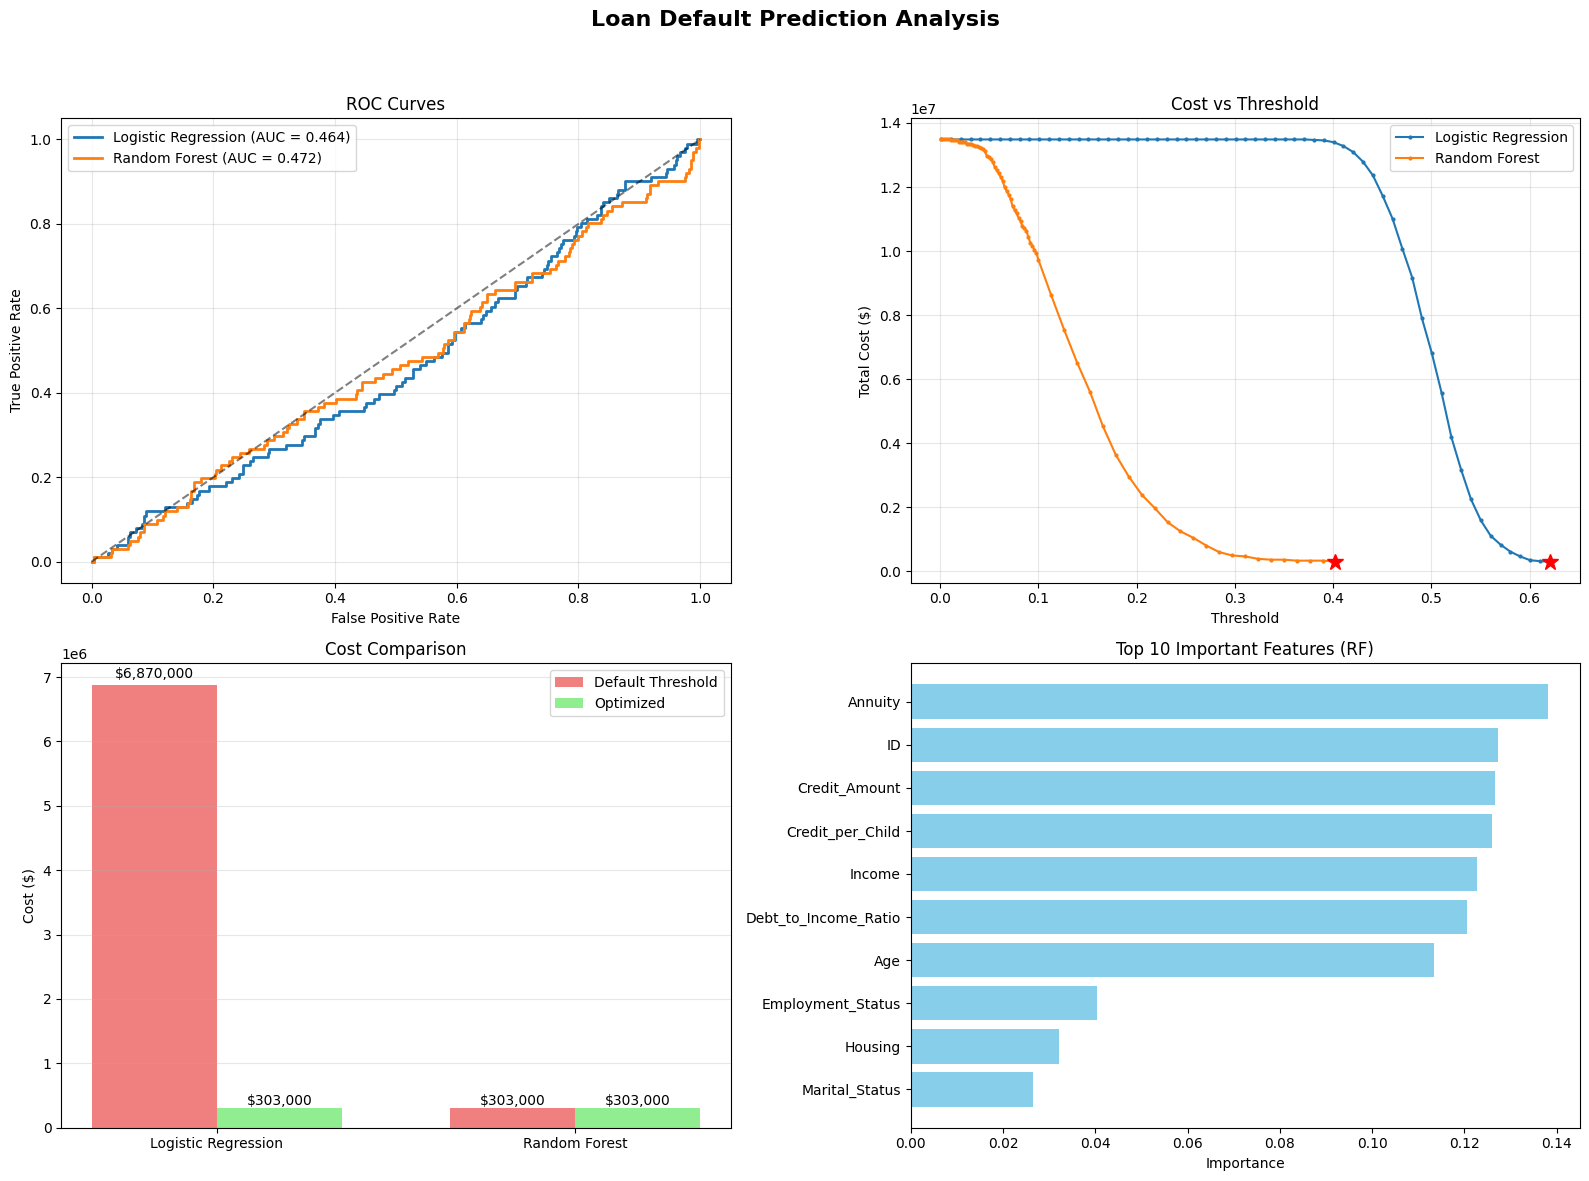

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle('Loan Default Prediction Analysis', fontsize=16, fontweight='bold')

# Chart 1: ROC Curve
ax1 = axes[0, 0]
for model_name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probabilities'])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title("ROC Curves")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: Cost vs Threshold
ax2 = axes[0, 1]
for model_name, res in results.items():
    ax2.plot(res['all_thresholds'], res['all_costs'], label=model_name, marker='o', markersize=2)
    idx = np.argmin(res['all_costs'])
    ax2.plot(res['all_thresholds'][idx], res['all_costs'][idx], 'r*', markersize=12)
ax2.set_title("Cost vs Threshold")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Total Cost ($)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Chart 3: Cost Comparison
ax3 = axes[1, 0]
model_names = list(results.keys())
default_costs = [results[m]['default_cost'] for m in model_names]
optimal_costs = [results[m]['optimal_cost'] for m in model_names]
x = np.arange(len(model_names))
width = 0.35
bars1 = ax3.bar(x - width/2, default_costs, width, label="Default Threshold", color='lightcoral')
bars2 = ax3.bar(x + width/2, optimal_costs, width, label="Optimized", color='lightgreen')
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., h + h*0.01, f"${h:,.0f}", ha='center', va='bottom', fontsize=10)
ax3.set_xticks(x)
ax3.set_xticklabels(model_names)
ax3.set_ylabel("Cost ($)")
ax3.set_title("Cost Comparison")
ax3.legend()
ax3.grid(True, axis='y', alpha=0.3)

# Chart 4: Feature Importance (Random Forest)
ax4 = axes[1, 1]
if 'Random Forest' in results:
    importances = results['Random Forest']['model'].feature_importances_
    sorted_idx = np.argsort(importances)[::-1][:10]
    top_features = [feature_names[i] for i in sorted_idx]
    top_scores = importances[sorted_idx]
    ax4.barh(np.arange(len(top_features)), top_scores, color='skyblue')
    ax4.set_yticks(np.arange(len(top_features)))
    ax4.set_yticklabels(top_features)
    ax4.set_title("Top 10 Important Features (RF)")
    ax4.set_xlabel("Importance")
    ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, "Feature Importance Not Available", ha='center', va='center', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
print("BUSINESS IMPACT REPORT")

# Find model with lowest optimal cost
best_model_name = min(results, key=lambda x: results[x]['optimal_cost'])
best = results[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"   Optimal Threshold: {best['optimal_threshold']:.3f}")
print(f"   Expected Annual Cost Reduction: ${best['cost_savings']:,}")

print("\nCost Structure:")
print(f"   Cost per Bad Loan Approved (False Positive): ${cost_fp:,}")
print(f"   Cost per Good Loan Rejected (False Negative): ${cost_fn:,}")

print("\nPerformance:")
print(f"   Accuracy: {best['optimal_accuracy']:.2%}")
print(f"   Total Cost: ${best['optimal_cost']:,}")
print(f"   False Positives: {best['optimal_fp']}, False Negatives: {best['optimal_fn']}")

print("\nImprovement Over Threshold:")
print(f"   Default Cost: ${best['default_cost']:,}")
print(f"   Cost Savings: ${best['cost_savings']:,}")
print(f"   Percent Improvement: {100 * best['cost_savings'] / best['default_cost']:.1f}%")

print("\nRecommendation:")
print(f"   → Use {best_model_name} with threshold {best['optimal_threshold']:.3f}")
print(f"   → Retrain monthly & monitor business metrics")
print(f"   → Track false positives and negatives over time")


BUSINESS IMPACT REPORT

Best Model: Logistic Regression
   Optimal Threshold: 0.620
   Expected Annual Cost Reduction: $6,567,000

Cost Structure:
   Cost per Bad Loan Approved (False Positive): $15,000
   Cost per Good Loan Rejected (False Negative): $3,000

Performance:
   Accuracy: 89.90%
   Total Cost: $303,000
   False Positives: 0, False Negatives: 101

Improvement Over Threshold:
   Default Cost: $6,870,000
   Cost Savings: $6,567,000
   Percent Improvement: 95.6%

Recommendation:
   → Use Logistic Regression with threshold 0.620
   → Retrain monthly & monitor business metrics
   → Track false positives and negatives over time


# Conclusion
Key Insights:
- Employment Status & Marital Status Influence Default Risk: Applicants who were unemployed or single had a higher likelihood of defaulting on their loans, indicating potential risk groups.
- Higher Credit Amounts and Lower Incomes Raise Default Probability: A high Credit Amount relative to Income (debt-to-income ratio) was a strong predictor of default. This suggests financial strain contributes significantly to default risk.
- Age and Annuity Levels Show Predictive Power: Younger applicants and those with higher annuity payments were more likely to default, possibly due to lower financial stability or higher repayment burdens.
- Imbalance in Target Variable: The dataset is highly imbalanced, with a small proportion of defaults. This required special handling (e.g., class weights) to ensure models could detect defaulters effectively.
- Model Performance: Models such as Random Forest and Logistic Regression were used. Despite class imbalance, both provided useful insights into feature importance and risk patterns.